In [506]:
import matplotlib.pyplot as plt
import matplotlib
# %matplotlib qt

import numpy as np
from numpy import *
from scipy.fft import fft, ifft, fftshift, ifftshift
from scipy.optimize import curve_fit
from matplotlib.colors import LinearSegmentedColormap

import os
import scipy.io as sio

# def linear_func(f, A1, B):
#     return (A1/f) + B

# def linear_fit(x_data, y_data):
#     valid = (x_data > 0) & (y_data > 0) & np.isfinite(y_data)
#     x_clean = x_data[valid]
#     y_clean = y_data[valid]
#     params, params_cov = curve_fit(
#         linear_func,
#         x_clean,
#         y_clean)
#     A1, B = params
#     return A1, B


def linear_func(x, a, b):
    return a * x + b

def linear_fit(x, y):
    popt, pcov = curve_fit(linear_func, x, y)
    a = popt[0]
    b = popt[1]
#     a_err = np.sqrt(pcov[0, 0])
#     b_err = np.sqrt(pcov[1, 1])
    return a, b

In [507]:
initial_folder = r'C:\Users\Demag\PycharmProjects\ColdMeasurements\DeMag\DATA\TWPA_noise_9'

folders = os.listdir(initial_folder)
for i in range(len(folders)):
    if ".fig" in folders[i]: pass
    else: 
        print(r"[%d]" %(i), '----------->', folders[i])

[0] -----------> 1st_tone
[1] -----------> Alan_var
[2] -----------> Best_noise_power_sweep
[3] -----------> Best_noise_power_sweep_last_plot
[4] -----------> fast_saturation
[5] -----------> Gain_sweep_1000mK2025-07-17-22-37-20.mat
[6] -----------> Gain_sweep_10mK_power_freq2025-07-21-19-09-34.mat
[7] -----------> Gain_sweep_10mK_power_freq_1.382025-07-22-02-40-22.mat
[8] -----------> Gain_sweep_10mK_power_sweep_0.412025-07-22-12-30-24.mat
[9] -----------> Gain_sweep_10mK_power_sweep_0.412025-07-22-12-38-47.mat
[10] -----------> Gain_sweep_10mK_power_sweep_0.412025-07-22-12-40-36.mat
[11] -----------> Gain_sweep_12mK2025-05-29-12-17-35.mat
[12] -----------> Gain_sweep_12mK2025-05-29-13-27-37.mat
[13] -----------> Gain_sweep_12mK2025-06-03-10-58-46.mat
[14] -----------> Gain_sweep_12mK2025-06-03-18-18-22.mat
[15] -----------> Gain_sweep_12mK_test_save2025-06-05-17-57-06.mat
[16] -----------> Gain_sweep_500mK2025-07-08-15-36-23.mat
[17] -----------> Gain_sweep_700mK2025-07-12-17-11-02.m

In [508]:
file = folders[49]
mat_01 = sio.loadmat(initial_folder+"\\"+file)
mat_01.keys()

dict_keys(['__header__', '__version__', '__globals__', 'pump_powers', 'pump_freqs', 'volts', 'data_gain', 'data_mag', 'data_pha', 'fft_freq'])

In [509]:
file = folders[49]
mat_01 = sio.loadmat(initial_folder+"\\"+file)
mat_01.keys()
BW = 10

In [510]:
data_gain_01 = mat_01['data_gain'][:,:,0]
print(data_gain_01.shape)
volts_01 = mat_01['volts'][0]
print(volts_01[4])
pump_freqs_01 = mat_01['pump_freqs'][0]
print(pump_freqs_01[2])
pump_powers_01 = mat_01['pump_powers'][0]
print(pump_powers_01[0])
data_mag_01 = mat_01['data_mag'][:,:,0]/ len(fft_freq) / BW * 2 # on/off
print(data_mag_01.shape)
data_pha_01 = mat_01['data_pha'][:,:,0]/ len(fft_freq) / BW * 2 # on/off
print(data_pha_01.shape)
fft_freq_01 = mat_01['fft_freq'][0] # on/off
print(fft_freq_01.shape)

(101, 501)
0.6
9018000000.0
7.0
(101, 501, 2, 101)
(101, 501, 2, 101)
(101,)


In [511]:
noise_mag_01 = np.ones((len(volts_01), len(pump_freqs_01)))*-9
noise_pha_01 = np.ones((len(volts_01), len(pump_freqs_01)))*-9

noise_mag_ref_01 = np.ones((len(volts_01), len(pump_freqs_01)))*-9
noise_pha_ref_01 = np.ones((len(volts_01), len(pump_freqs_01)))*-9

cut_pos = 51
cut_white = -5
x = fft_freq_01[cut_pos:]

for pf_idx in range(len(pump_freqs_01)):
    for v_idx in range(len(volts_01)):
        
        mag_curr_01 = data_mag_01[v_idx, pf_idx, 0]
        mag_curr_ref_01 = data_mag_01[v_idx, pf_idx, 1]
        
        pha_curr_01 = data_pha_01[v_idx, pf_idx, 0]
        pha_curr_ref_01 = data_pha_01[v_idx, pf_idx, 1]
        
        gain_curr_01 = data_gain_01[v_idx, pf_idx]
           
        y = mag_curr_01[cut_pos:]/np.power(10, gain_curr_01/10)
        try:
            am, bm = linear_fit(np.log10(x[1:cut_white]), np.log10(y[1:cut_white]))
            noise_mag_01[v_idx, pf_idx] = linear_func(np.log10(1), am, bm)
        except: pass
        

        y = mag_curr_ref_01[cut_pos:]
        try: 
            am, bm = linear_fit(np.log10(x[1:cut_white]), np.log(y[1:cut_white]))
            noise_mag_ref_01[v_idx, pf_idx] = linear_func(np.log(1), am, bm)
        except: pass

        y = pha_curr_01[cut_pos:]
        try:
            am, bm = linear_fit(np.log10(x[1:cut_white]), np.log10(y[1:cut_white]))
            noise_pha_01[v_idx, pf_idx] = linear_func(np.log10(1), am, bm)
        except: pass
    
        y = pha_curr_ref_01[cut_pos:]
        try:
            am, bm, am_err, bm_err = linear_fit(np.log10(x[1:cut_white]), np.log10(y[1:cut_white]))
            noise_pha_ref_01[v_idx, pf_idx] = linear_func(np.log10(1), am, bm)
        except: pass

C:\Users\Demag\AppData\Local\Temp\ipykernel_8144\3787272947.py:24: RuntimeWarning: divide by zero encountered in log10
  am, bm = linear_fit(np.log10(x[1:cut_white]), np.log10(y[1:cut_white]))
C:\Users\Demag\AppData\Local\Temp\ipykernel_8144\3787272947.py:31: RuntimeWarning: divide by zero encountered in log
  am, bm = linear_fit(np.log10(x[1:cut_white]), np.log(y[1:cut_white]))
C:\Users\Demag\AppData\Local\Temp\ipykernel_8144\3787272947.py:37: RuntimeWarning: divide by zero encountered in log10
  am, bm = linear_fit(np.log10(x[1:cut_white]), np.log10(y[1:cut_white]))
C:\Users\Demag\AppData\Local\Temp\ipykernel_8144\3787272947.py:43: RuntimeWarning: divide by zero encountered in log10
  am, bm, am_err, bm_err = linear_fit(np.log10(x[1:cut_white]), np.log10(y[1:cut_white]))


In [512]:
file = folders[44]
mat_07 = sio.loadmat(initial_folder+"\\"+file)
mat_07.keys()

dict_keys(['__header__', '__version__', '__globals__', 'pump_powers', 'pump_freqs', 'volts', 'data_gain', 'data_mag', 'data_pha', 'fft_freq'])

In [513]:
data_gain_07 = mat_07['data_gain'][:,:,0]
print(data_gain_07.shape)
volts_07 = mat_07['volts'][0]
print(volts_07[4])
pump_freqs_07 = mat_07['pump_freqs'][0]
print(pump_freqs_07[2])
pump_powers_07 = mat_07['pump_powers'][0]
print(pump_powers_07[0])
data_mag_07 = mat_07['data_mag'][:,:,0]/ len(fft_freq) / BW * 2 # on/off
print(data_mag_07.shape)
data_pha_07 = mat_07['data_pha'][:,:,0]/ len(fft_freq) / BW * 2 # on/off
print(data_pha_07.shape)
fft_freq_07 = mat_07['fft_freq'][0] # on/off
print(fft_freq_07.shape)

(35, 501)
0.7
9022000000.0
6.0
(35, 501, 2, 101)
(35, 501, 2, 101)
(101,)


In [329]:
noise_mag_07 = np.ones((len(volts_07), len(pump_freqs_07)))*-9
noise_pha_07 = np.ones((len(volts_07), len(pump_freqs_07)))*-9

noise_mag_ref_07 = np.ones((len(volts_07), len(pump_freqs_07)))*-9
noise_pha_ref_07 = np.ones((len(volts_07), len(pump_freqs_07)))*-9

cut_pos = 51
cut_white = -5
x = fft_freq_07[cut_pos:]

for pf_idx in range(len(pump_freqs_07)):
    for v_idx in range(len(volts_07)):
        
        mag_curr_07 = data_mag_07[v_idx, pf_idx, 0]
        mag_curr_ref_07 = data_mag_07[v_idx, pf_idx, 1]
        
        pha_curr_07 = data_pha_07[v_idx, pf_idx, 0]
        pha_curr_ref_07 = data_pha_07[v_idx, pf_idx, 1]
        
        gain_curr_07 = data_gain_07[v_idx, pf_idx]
           
        y = mag_curr_07[cut_pos:]/np.power(10, gain_curr_07/10)
        try:
            am, bm = linear_fit(np.log10(x[1:cut_white]), np.log10(y[1:cut_white]))
            noise_mag_07[v_idx, pf_idx] = linear_func(np.log10(1), am, bm)
        except: pass
        

        y = mag_curr_ref_07[cut_pos:]/np.power(10, gain_curr_07/10)
        try: 
            am, bm = linear_fit(np.log10(x[1:cut_white]), np.log(y[1:cut_white]))
            noise_mag_ref_07[v_idx, pf_idx] = linear_func(np.log(1), am, bm)
        except: pass

        y = pha_curr_07[cut_pos:]
        try:
            am, bm = linear_fit(np.log10(x[1:cut_white]), np.log10(y[1:cut_white]))
            noise_pha_07[v_idx, pf_idx] = linear_func(np.log10(1), am, bm)
        except: pass
    
        y = pha_curr_ref_07[cut_pos:]
        try:
            am, bm, am_err, bm_err = linear_fit(np.log10(x[1:cut_white]), np.log10(y[1:cut_white]))
            noise_pha_ref_07[v_idx, pf_idx] = linear_func(np.log10(1), am, bm)
        except: pass

C:\Users\Demag\AppData\Local\Temp\ipykernel_8144\3163709146.py:24: RuntimeWarning: divide by zero encountered in log10
  am, bm = linear_fit(np.log10(x[1:cut_white]), np.log10(y[1:cut_white]))
C:\Users\Demag\AppData\Local\Temp\ipykernel_8144\3163709146.py:31: RuntimeWarning: divide by zero encountered in log
  am, bm = linear_fit(np.log10(x[1:cut_white]), np.log(y[1:cut_white]))
C:\Users\Demag\AppData\Local\Temp\ipykernel_8144\3163709146.py:37: RuntimeWarning: divide by zero encountered in log10
  am, bm = linear_fit(np.log10(x[1:cut_white]), np.log10(y[1:cut_white]))
C:\Users\Demag\AppData\Local\Temp\ipykernel_8144\3163709146.py:43: RuntimeWarning: divide by zero encountered in log10
  am, bm, am_err, bm_err = linear_fit(np.log10(x[1:cut_white]), np.log10(y[1:cut_white]))


In [315]:
file = folders[41]
mat_05 = sio.loadmat(initial_folder+"\\"+file)
mat_05.keys()

dict_keys(['__header__', '__version__', '__globals__', 'pump_powers', 'pump_freqs', 'volts', 'data_gain', 'data_mag', 'data_pha', 'fft_freq'])

In [316]:
data_gain_05 = mat_05['data_gain'][:,:,0]
print(data_gain_05.shape)
volts_05 = mat_05['volts'][0]
print(volts_05[0])
pump_freqs_05 = mat_05['pump_freqs'][0]
print(pump_freqs_05[2])
pump_powers_05 = mat_05['pump_powers'][0]
print(pump_powers_05[0])
data_mag_05 = mat_05['data_mag'][:,:,0]/ len(fft_freq) / BW * 2 # on/off
print(data_mag_05.shape)
data_pha_05 = mat_05['data_pha'][:,:,0]/ len(fft_freq) / BW * 2 # on/off
print(data_pha_05.shape)
fft_freq_05 = mat_05['fft_freq'][0] # on/off
print(fft_freq_05.shape)

(35, 501)
0.5
9022000000.0
6.0
(35, 501, 2, 101)
(35, 501, 2, 101)
(101,)


In [318]:
noise_mag_05 = np.ones((len(volts_05), len(pump_freqs_05)))*-9
noise_pha_05 = np.ones((len(volts_05), len(pump_freqs_05)))*-9

noise_mag_ref_05 = np.ones((len(volts_05), len(pump_freqs_05)))*-9
noise_pha_ref_05 = np.ones((len(volts_05), len(pump_freqs_05)))*-9

cut_pos = 51
cut_white = -5
x = fft_freq_05[cut_pos:]

for pf_idx in range(len(pump_freqs_05)):
    for v_idx in range(len(volts_05)):
        
        mag_curr_05 = data_mag_05[v_idx, pf_idx, 0]
        mag_curr_ref_05 = data_mag_05[v_idx, pf_idx, 1]
        
        pha_curr_05 = data_pha_05[v_idx, pf_idx, 0]
        pha_curr_ref_05 = data_pha_05[v_idx, pf_idx, 1]
        
        gain_curr_05 = data_gain_05[v_idx, pf_idx]
           
        y = mag_curr_05[cut_pos:]/np.power(10, gain_curr_05/10)
        try:
            am, bm = linear_fit(np.log10(x[1:cut_white]), np.log10(y[1:cut_white]))
            noise_mag_05[v_idx, pf_idx] = linear_func(np.log10(1), am, bm)
        except: pass
        

        y = mag_curr_ref_05[cut_pos:]/np.power(10, gain_curr_05/10)
        try: 
            am, bm = linear_fit(np.log10(x[1:cut_white]), np.log(y[1:cut_white]))
            noise_mag_ref_05[v_idx, pf_idx] = linear_func(np.log(1), am, bm)
        except: pass

        y = pha_curr_05[cut_pos:]
        try:
            am, bm = linear_fit(np.log10(x[1:cut_white]), np.log10(y[1:cut_white]))
            noise_pha_05[v_idx, pf_idx] = linear_func(np.log10(1), am, bm)
        except: pass
    
        y = pha_curr_ref_05[cut_pos:]
        try:
            am, bm, am_err, bm_err = linear_fit(np.log10(x[1:cut_white]), np.log10(y[1:cut_white]))
            noise_pha_ref_05[v_idx, pf_idx] = linear_func(np.log10(1), am, bm)
        except: pass

C:\Users\Demag\AppData\Local\Temp\ipykernel_8144\3371604666.py:24: RuntimeWarning: divide by zero encountered in log10
  am, bm = linear_fit(np.log10(x[1:cut_white]), np.log10(y[1:cut_white]))
C:\Users\Demag\AppData\Local\Temp\ipykernel_8144\3371604666.py:31: RuntimeWarning: divide by zero encountered in log
  am, bm = linear_fit(np.log10(x[1:cut_white]), np.log(y[1:cut_white]))
C:\Users\Demag\AppData\Local\Temp\ipykernel_8144\3371604666.py:37: RuntimeWarning: divide by zero encountered in log10
  am, bm = linear_fit(np.log10(x[1:cut_white]), np.log10(y[1:cut_white]))
C:\Users\Demag\AppData\Local\Temp\ipykernel_8144\3371604666.py:43: RuntimeWarning: divide by zero encountered in log10
  am, bm, am_err, bm_err = linear_fit(np.log10(x[1:cut_white]), np.log10(y[1:cut_white]))


In [319]:
file = folders[23]
mat_1k = sio.loadmat(initial_folder+"\\"+file)
mat_1k.keys()

dict_keys(['__header__', '__version__', '__globals__', 'pump_powers', 'pump_freqs', 'volts', 'data_gain', 'data_mag', 'data_pha', 'fft_freq'])

In [320]:
data_gain_1k = mat_1k['data_gain'][:,:,0]
print(data_gain_1k.shape)
volts_1k = mat_1k['volts'][0]
print(volts_1k[4])
pump_freqs_1k = mat_1k['pump_freqs'][0]
print(pump_freqs_1k[2])
pump_powers_1k = mat_1k['pump_powers'][0]
print(pump_powers_1k[0])
data_mag_1k = mat_1k['data_mag'][:,:,0]/ len(fft_freq) / BW * 2 # on/off
print(data_mag_1k.shape)
data_pha_1k = mat_1k['data_pha'][:,:,0]/ len(fft_freq) / BW * 2 # on/off
print(data_pha_1k.shape)
fft_freq_1k = mat_1k['fft_freq'][0] # on/off
print(fft_freq_1k.shape)

(35, 501)
0.7
9022000000.0
6.0
(35, 501, 2, 101)
(35, 501, 2, 101)
(101,)


In [322]:
noise_mag_1k = np.ones((len(volts_1k), len(pump_freqs_1k)))*-9
noise_pha_1k = np.ones((len(volts_1k), len(pump_freqs_1k)))*-9

noise_mag_ref_1k = np.ones((len(volts_1k), len(pump_freqs_1k)))*-9
noise_pha_ref_1k = np.ones((len(volts_1k), len(pump_freqs_1k)))*-9

cut_pos = 51
cut_white = -5
x = fft_freq_1k[cut_pos:]

for pf_idx in range(len(pump_freqs_1k)):
    for v_idx in range(len(volts_1k)):
        
        mag_curr_1k = data_mag_1k[v_idx, pf_idx, 0]
        mag_curr_ref_1k = data_mag_1k[v_idx, pf_idx, 1]
        
        pha_curr_1k = data_pha_1k[v_idx, pf_idx, 0]
        pha_curr_ref_1k = data_pha_1k[v_idx, pf_idx, 1]
        
        gain_curr_1k = data_gain_1k[v_idx, pf_idx]
           
        y = mag_curr_1k[cut_pos:]/np.power(10, gain_curr_1k/10)
        try:
            am, bm = linear_fit(np.log10(x[1:cut_white]), np.log10(y[1:cut_white]))
            noise_mag_1k[v_idx, pf_idx] = linear_func(np.log10(1), am, bm)
        except: pass
        

        y = mag_curr_ref_1k[cut_pos:]/np.power(10, gain_curr_1k/10)
        try: 
            am, bm = linear_fit(np.log10(x[1:cut_white]), np.log(y[1:cut_white]))
            noise_mag_ref_1k[v_idx, pf_idx] = linear_func(np.log(1), am, bm)
        except: pass

        y = pha_curr_1k[cut_pos:]
        try:
            am, bm = linear_fit(np.log10(x[1:cut_white]), np.log10(y[1:cut_white]))
            noise_pha_1k[v_idx, pf_idx] = linear_func(np.log10(1), am, bm)
        except: pass
    
        y = pha_curr_ref_1k[cut_pos:]
        try:
            am, bm, am_err, bm_err = linear_fit(np.log10(x[1:cut_white]), np.log10(y[1:cut_white]))
            noise_pha_ref_1k[v_idx, pf_idx] = linear_func(np.log10(1), am, bm)
        except: pass

C:\Users\Demag\AppData\Local\Temp\ipykernel_8144\2198206519.py:24: RuntimeWarning: divide by zero encountered in log10
  am, bm = linear_fit(np.log10(x[1:cut_white]), np.log10(y[1:cut_white]))
C:\Users\Demag\AppData\Local\Temp\ipykernel_8144\2198206519.py:31: RuntimeWarning: divide by zero encountered in log
  am, bm = linear_fit(np.log10(x[1:cut_white]), np.log(y[1:cut_white]))
C:\Users\Demag\AppData\Local\Temp\ipykernel_8144\2198206519.py:37: RuntimeWarning: divide by zero encountered in log10
  am, bm = linear_fit(np.log10(x[1:cut_white]), np.log10(y[1:cut_white]))
C:\Users\Demag\AppData\Local\Temp\ipykernel_8144\2198206519.py:43: RuntimeWarning: divide by zero encountered in log10
  am, bm, am_err, bm_err = linear_fit(np.log10(x[1:cut_white]), np.log10(y[1:cut_white]))


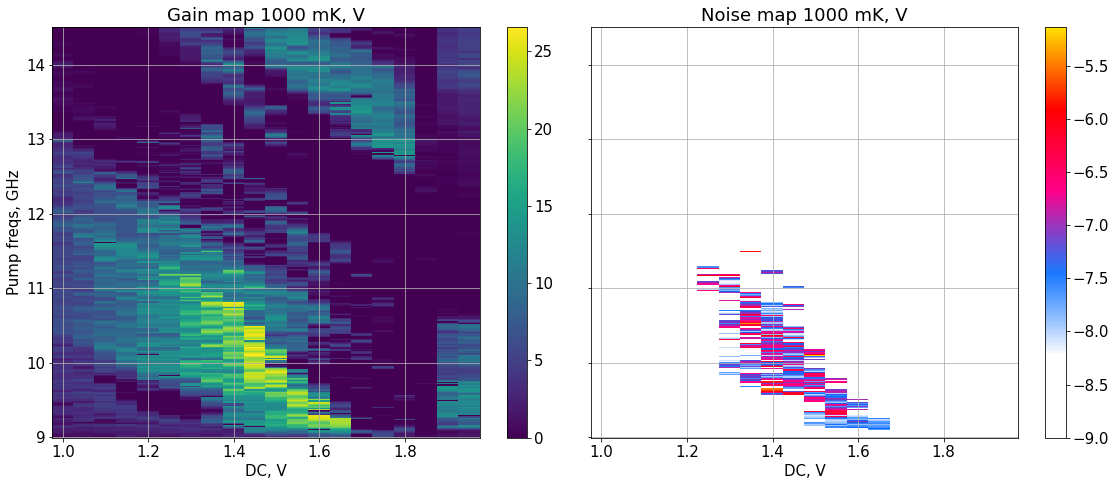

In [323]:
font = {'size'   : 15}
matplotlib.rc('font', **font)

volts = volts_1k
data = data_gain_1k
data_mag = data_mag_1k
data_pha = data_pha_1k
fft_freq = fft_freq_1k
pump_freqs = pump_freqs_1k
noise_mag = noise_mag_1k
noise_pha = noise_pha_1k

fig2, ax = plt.subplots(1, 2, figsize=(16,7), sharex = True, sharey = True)

for i in range(len(volts)):
    for j in range(len(pump_freqs)):
        if data[i,j]<0: data[i,j] = 0

c1 = ax[0].pcolor(volts[10:-5], pump_freqs / 1e9, data[10:-5].T, cmap='viridis')
ax[0].set_title(r'Gain map 1000 mK, V')
ax[0].set_xlabel(r'DC, V')
ax[0].set_ylabel(r'Pump freqs, GHz')
ax[0].grid(True)
fig.colorbar(c1, ax=ax[0], orientation='vertical')

colors2 = ['#ffffff', '#ffffff',  '#006affe5', '#ff008aff', '#ff0000ff', '#ffde00ff']
cmap2 = LinearSegmentedColormap.from_list('my_cmap', colors2, N=256)


c3 = ax[1].pcolor(volts[10:-5], pump_freqs / 1e9, noise_mag[10:-5].T, cmap=cmap2)
ax[1].set_title(r'Noise map 1000 mK, V')
ax[1].set_xlabel(r'DC, V')
ax[1].grid(True)
fig.colorbar(c3, ax=ax[1], orientation='vertical')
plt.tight_layout()
plt.show()

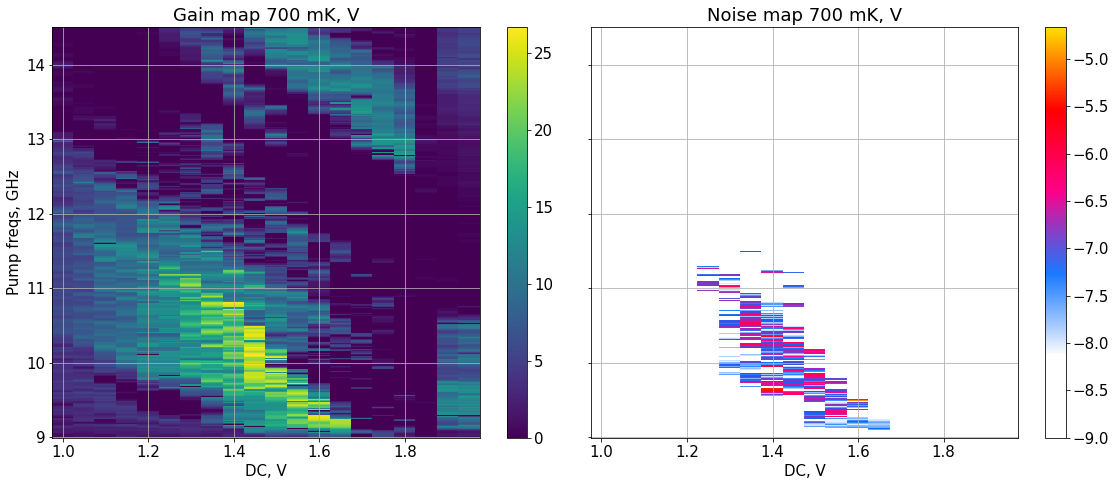

In [330]:
font = {'size'   : 15}
matplotlib.rc('font', **font)

volts = volts_07
data = data_gain_07
data_mag = data_mag_07
data_pha = data_pha_07
fft_freq = fft_freq_07
pump_freqs = pump_freqs_07
noise_mag = noise_mag_07
noise_pha = noise_pha_07

for i in range(len(volts)):
    for j in range(len(pump_freqs)):
        if data[i,j]<0: data[i,j] = 0

            
fig2, ax = plt.subplots(1, 2, figsize=(16,7), sharex = True, sharey = True)

c1 = ax[0].pcolor(volts[10:-5], pump_freqs / 1e9, data[10:-5].T, cmap='viridis')
ax[0].set_title(r'Gain map 700 mK, V')
ax[0].set_xlabel(r'DC, V')
ax[0].set_ylabel(r'Pump freqs, GHz')
ax[0].grid(True)
fig.colorbar(c1, ax=ax[0], orientation='vertical')

colors2 = ['#ffffff', '#ffffff',  '#006affe5', '#ff008aff', '#ff0000ff', '#ffde00ff']
cmap2 = LinearSegmentedColormap.from_list('my_cmap', colors2, N=256)


c3 = ax[1].pcolor(volts[10:-5], pump_freqs / 1e9, noise_mag[10:-5].T, cmap=cmap2)
ax[1].set_title(r'Noise map 700 mK, V')
ax[1].set_xlabel(r'DC, V')
ax[1].grid(True)
fig.colorbar(c3, ax=ax[1], orientation='vertical')
plt.tight_layout()
plt.show()

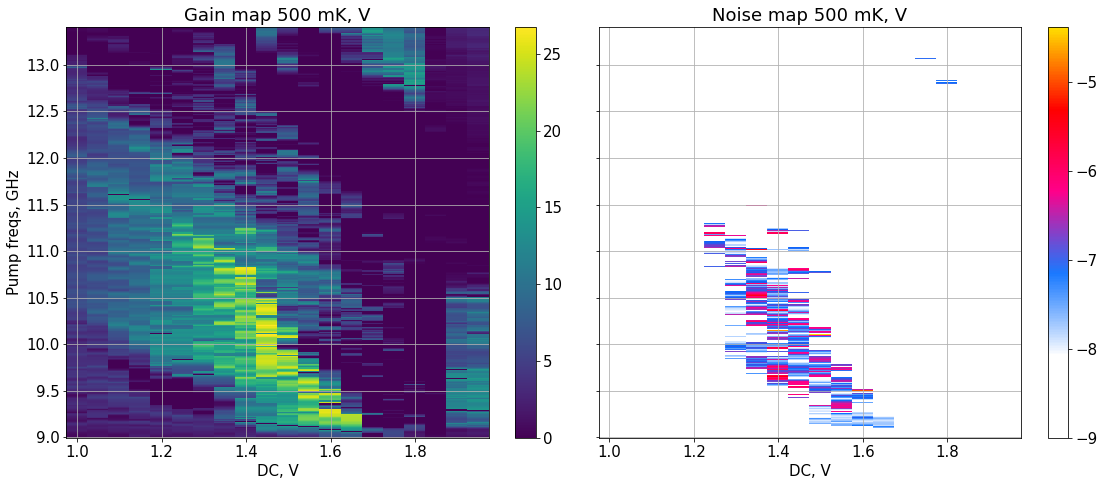

In [325]:
font = {'size'   : 15}
matplotlib.rc('font', **font)

volts = volts_05
data = data_gain_05
data_mag = data_mag_05
data_pha = data_pha_05
fft_freq = fft_freq_05
pump_freqs = pump_freqs_05
noise_mag = noise_mag_05
noise_pha = noise_pha_05

for i in range(len(volts)):
    for j in range(len(pump_freqs)):
        if data[i,j]<0: data[i,j] = 0

fig2, ax = plt.subplots(1, 2, figsize=(16,7), sharex = True, sharey = True)

c1 = ax[0].pcolor(volts[10:-5], pump_freqs[:-100]  / 1e9, data[10:-5, :-100].T, cmap='viridis')
ax[0].set_title(r'Gain map 500 mK, V')
ax[0].set_xlabel(r'DC, V')
ax[0].set_ylabel(r'Pump freqs, GHz')
ax[0].grid(True)
fig.colorbar(c1, ax=ax[0], orientation='vertical')

colors2 = ['#ffffff', '#ffffff', '#006affe5', '#ff008aff', '#ff0000ff', '#ffde00ff']
cmap2 = LinearSegmentedColormap.from_list('my_cmap', colors2, N=256)


c3 = ax[1].pcolor(volts[10:-5], pump_freqs[:-100] / 1e9, noise_mag[10:-5, :-100].T, cmap=cmap2)
ax[1].set_title(r'Noise map 500 mK, V')
ax[1].set_xlabel(r'DC, V')
ax[1].grid(True)
fig.colorbar(c3, ax=ax[1], orientation='vertical')
plt.tight_layout()
plt.show()

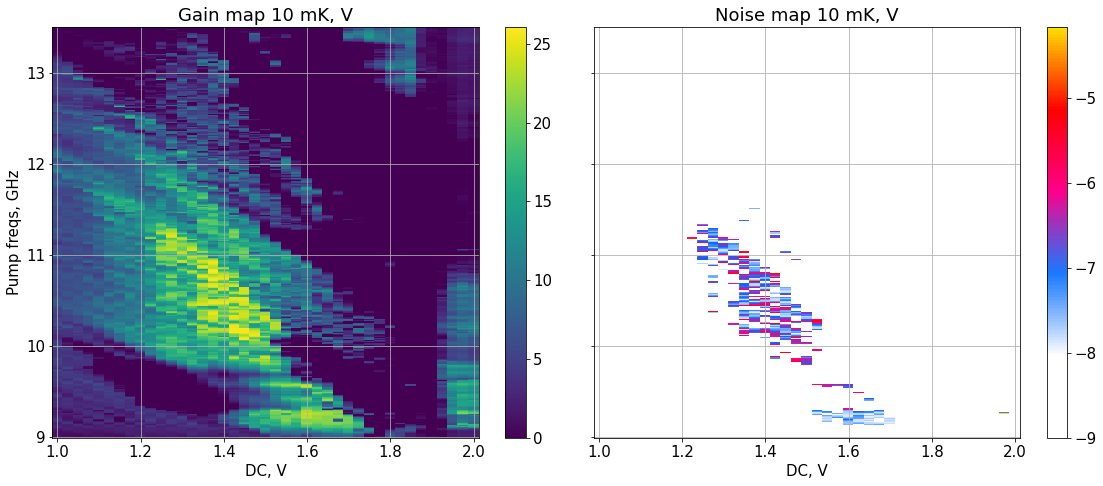

In [478]:
font = {'size'   : 15}
matplotlib.rc('font', **font)

volts = volts_01
data = data_gain_01
data_mag = data_mag_01
data_pha = data_pha_01
fft_freq = fft_freq_01
pump_freqs = pump_freqs_01
noise_mag = noise_mag_01
noise_pha = noise_pha_01

for i in range(len(volts)):
    for j in range(len(pump_freqs)):
        if data[i,j]<0: data[i,j] = 0


fig2, ax = plt.subplots(1, 2, figsize=(16,7), sharex = True, sharey = True)

c1 = ax[0].pcolor(volts[20:-40], pump_freqs / 1e9, data[20:-40].T, cmap='viridis')
ax[0].set_title(r'Gain map 10 mK, V')
ax[0].set_xlabel(r'DC, V')
ax[0].set_ylabel(r'Pump freqs, GHz')
ax[0].grid(True)
fig.colorbar(c1, ax=ax[0], orientation='vertical')

colors2 = ['#ffffff', '#ffffff',  '#006affe5', '#ff008aff', '#ff0000ff', '#ffde00ff']
cmap2 = LinearSegmentedColormap.from_list('my_cmap', colors2, N=256)


c3 = ax[1].pcolor(volts[20:-40], pump_freqs / 1e9, noise_mag[20:-40].T, cmap=cmap2)
ax[1].set_title(r'Noise map 10 mK, V')
ax[1].set_xlabel(r'DC, V')
ax[1].grid(True)
fig.colorbar(c3, ax=ax[1], orientation='vertical')
plt.tight_layout()
plt.show()

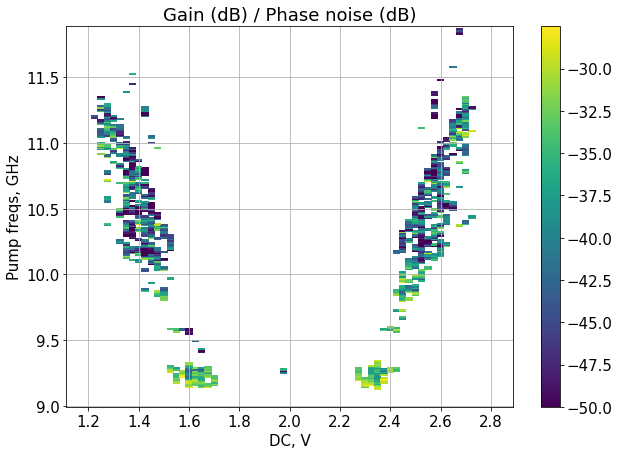

In [524]:
font = {'size'   : 15}
matplotlib.rc('font', **font)

import copy

volts = volts_01
data = copy.deepcopy(data_gain_01)
data_mag = copy.deepcopy(data_mag_01)
data_pha = data_pha_01
fft_freq = fft_freq_01
pump_freqs = pump_freqs_01
noise_mag = noise_mag_01
noise_pha = noise_pha_01


fig2, ax = plt.subplots(1, 1, figsize=(10,7), sharex = True, sharey = True)

for iij in range(len(volts)):
    for iil in range(len(pump_freqs_01)):
        if noise_mag[iij, iil]>-9:
            data[iij, iil] = data[iij, iil]/noise_pha[iij, iil]*10
        else: data[iij, iil] = None

c1 = ax.pcolor(volts[25:-5], pump_freqs[:-180] / 1e9, data[25:-5, :-180].T, cmap='viridis', vmin = -50)
ax.set_title(r'Gain (dB) / Phase noise (dB)')
ax.set_xlabel(r'DC, V')
ax.set_ylabel(r'Pump freqs, GHz')
ax.grid(True)
fig.colorbar(c1, ax=ax, orientation='vertical')

colors2 = ['#ffffff', '#ffffff',  '#006affe5', '#ff008aff', '#ff0000ff', '#ffde00ff']
cmap2 = LinearSegmentedColormap.from_list('my_cmap', colors2, N=256)



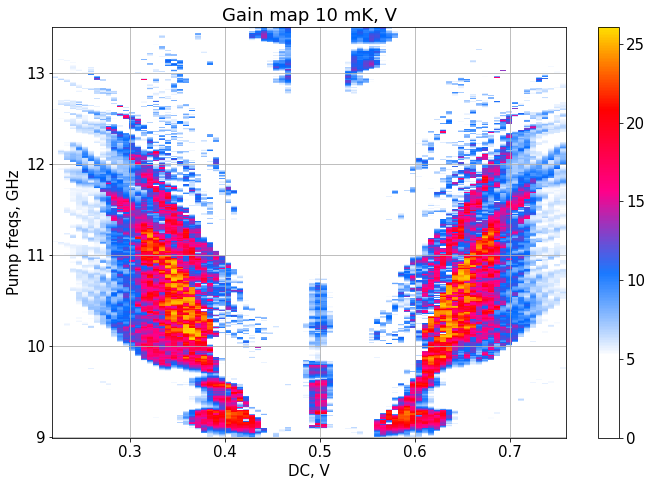

In [456]:
font = {'size'   : 15}
matplotlib.rc('font', **font)

volts = volts_01
data = data_gain_01
data_mag = data_mag_01
data_pha = data_pha_01
fft_freq = fft_freq_01
pump_freqs = pump_freqs_01
noise_mag = noise_mag_01
noise_pha = noise_pha_01

for i in range(len(volts)):
    for j in range(len(pump_freqs)):
        if data[i,j]<0: data[i,j] = 0


colors2 = ['#ffffff', '#ffffff',  '#006affe5', '#ff008aff', '#ff0000ff', '#ffde00ff']
cmap2 = LinearSegmentedColormap.from_list('my_cmap', colors2, N=256)

fig2, ax = plt.subplots(1, 1, figsize=(10,7), sharex = True, sharey = True)

c1 = ax.pcolor(volts[15:]/3.95*1.5/1.5055, pump_freqs / 1e9, data[15:].T, cmap=cmap2)
ax.set_title(r'Gain map 10 mK, V')
ax.set_xlabel(r'DC, V')
ax.set_ylabel(r'Pump freqs, GHz')
ax.grid(True)
fig.colorbar(c1, ax=ax, orientation='vertical')


plt.tight_layout()
plt.savefig(r"C:\Users\Demag\PycharmProjects\ColdMeasurements\DeMag\DATA\TWPA_noise_9\paper_plots\gainhh.png", dpi=300, bbox_inches='tight')
plt.show()

In [305]:
%matplotlib inline

In [331]:
def find_nearest_index(array, value):
    return (np.abs(array - value)).argmin()

In [345]:
mag_noise_05 = np.array([])
mag_noise_07 = np.array([])
mag_noise_1k = np.array([])
mag_ref_noise = np.array([])

mag_gain_05 = np.array([])
mag_gain_07 = np.array([])
mag_gain_1k = np.array([])
mag_gain_ref_noise = np.array([])

pha_noise_05 = np.array([])
pha_noise_07 = np.array([])
pha_noise_1k = np.array([])
pha_ref_noise = np.array([])

        
for i_dc_01 in range(len(volts_01)):
    for i_pf_01 in range(len(pump_freqs_01)):
        curr_dc = volts_01[i_dc_01]
        curr_pf = pump_freqs_01[i_pf_01]

        if noise_mag_01[i_dc_01, i_pf_01] > -9:
            


            dc_idx_05 = find_nearest_index(volts_05, curr_dc)
            dc_idx_07 = find_nearest_index(volts_07, curr_dc)
            dc_idx_1k = find_nearest_index(volts_1k, curr_dc)
            
            pf_idx_05 = find_nearest_index(pump_freqs_05, curr_pf)
            pf_idx_07 = find_nearest_index(pump_freqs_07, curr_pf)
            pf_idx_1k = find_nearest_index(pump_freqs_1k, curr_pf)
                

            if ((abs(curr_dc-volts_05[dc_idx_05])<abs(volts_05[1]-volts_05[0])) and
                (abs(curr_dc-volts_07[dc_idx_07])<abs(volts_07[1]-volts_07[0])) and 
                abs(curr_dc-volts_1k[dc_idx_1k])<abs(volts_1k[1]-volts_1k[0]) and 
                
                (abs(curr_pf-pump_freqs_05[pf_idx_05])<abs(pump_freqs_05[1]-pump_freqs_05[0])) and
                (abs(curr_pf-pump_freqs_07[pf_idx_07])<abs(pump_freqs_07[1]-pump_freqs_07[0])) and 
                abs(curr_pf-pump_freqs_1k[pf_idx_1k])<abs(pump_freqs_1k[1]-pump_freqs_1k[0])):
            


                mag_noise_05 = np.append(mag_noise_05, noise_mag_05[dc_idx_05, pf_idx_05])
                mag_noise_07 = np.append(mag_noise_07, noise_mag_07[dc_idx_07, pf_idx_07])
                mag_noise_1k = np.append(mag_noise_1k, noise_mag_1k[dc_idx_1k, pf_idx_1k])
                mag_ref_noise = np.append(mag_ref_noise, noise_mag_01[i_dc_01, i_pf_01])
                
                mag_gain_ref_noise = np.append(mag_gain_ref_noise, data_gain_01[i_dc_01, i_pf_01])
                mag_gain_05 = np.append(mag_gain_05, data_gain_05[dc_idx_05, pf_idx_05])
                mag_gain_07 = np.append(mag_gain_07, data_gain_07[dc_idx_07, pf_idx_07])
                mag_gain_1k = np.append(mag_gain_1k, data_gain_1k[dc_idx_1k, pf_idx_1k])
                
                pha_noise_05 = np.append(pha_noise_05, noise_pha_05[dc_idx_05, pf_idx_05])
                pha_noise_07 = np.append(pha_noise_07, noise_pha_07[dc_idx_07, pf_idx_07])
                pha_noise_1k = np.append(pha_noise_1k, noise_pha_1k[dc_idx_1k, pf_idx_1k])
                pha_ref_noise = np.append(pha_ref_noise, noise_pha_01[i_dc_01, i_pf_01])
                


print(len(curr_noise_1k)) 


4042


In [346]:
mag_ref_noise.shape

(664,)

In [347]:
mag_noise_1k.shape

(664,)

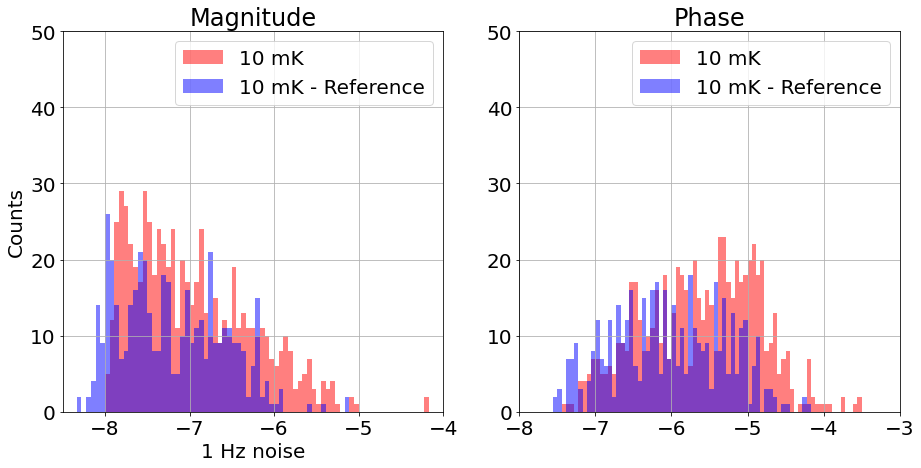

In [382]:
font = {'size'   : 20}
matplotlib.rc('font', **font)
fig, ax = plt.subplots(1, 2, figsize=(15,7))
ax[0].set_title("Magnitude")
ax[1].set_title("Phase")

ax[0].set_ylabel("Counts")
ax[0].set_xlabel("1 Hz noise")


bin_edges = np.linspace(-9, -3.5, 100)

ax[0].hist(mag_ref_noise, bins=bin_edges, alpha=0.5, label='10 mK', color='red')
# ax[0].hist(mag_noise_05[mag_noise_05 != -9], bins=bin_edges, alpha=0.4, label='500 mK', color='green')

ax[0].hist(mag_noise_1k, bins=bin_edges, alpha=0.5, label='10 mK - Reference', color='blue')
# ax[0].hist(mag_noise_07, bins=bin_edges, alpha=0.5, label='700mK', color='blue')


ax[1].hist(pha_ref_noise, bins=bin_edges, alpha=0.5, label='10 mK', color='red')
# ax[1].hist(pha_noise_05[pha_noise_05 != -9], bins=bin_edges, alpha=0.4, label='500 mK', color='green')

ax[1].hist(pha_noise_1k, bins=bin_edges, alpha=0.5, label='10 mK - Reference', color='blue')
# ax[1].hist(pha_noise_07, bins=bin_edges, alpha=0.5, label='700mK', color='blue')

ax[0].set_xlim(-8.5,-4)
ax[1].set_xlim(-8,-3)
ax[0].set_ylim(0,50)
ax[1].set_ylim(0,50)

ax[0].legend()
ax[0].grid(True)
ax[1].legend()
ax[1].grid(True)
plt.savefig(r"C:\Users\Demag\PycharmProjects\ColdMeasurements\DeMag\DATA\TWPA_noise_9\paper_plots\Temp_hist.png", dpi=300, bbox_inches='tight')
plt.show()

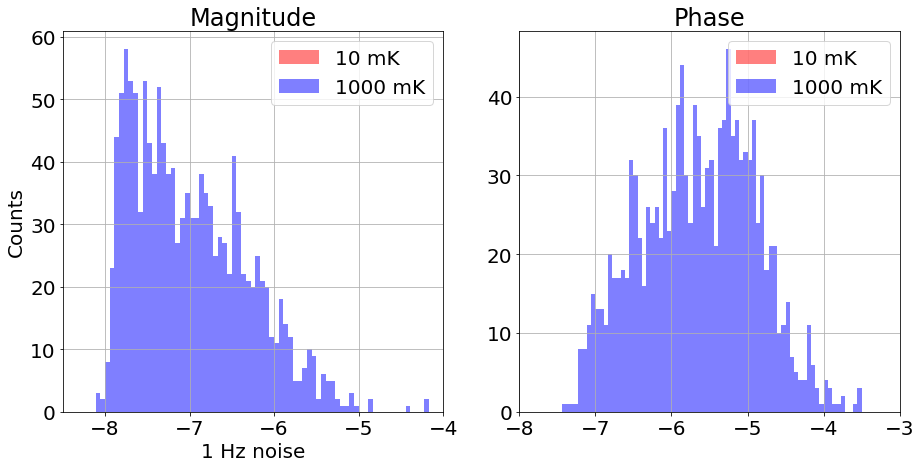

In [386]:
font = {'size'   : 20}
matplotlib.rc('font', **font)
fig, ax = plt.subplots(1, 2, figsize=(15,7))
ax[0].set_title("Magnitude")
ax[1].set_title("Phase")

ax[0].set_ylabel("Counts")
ax[0].set_xlabel("1 Hz noise")


bin_edges = np.linspace(-9, -3.5, 100)

ax[0].hist(noise_mag_ref_01[noise_mag_ref_01 != -9], bins=bin_edges, alpha=0.5, label='10 mK', color='red')
# ax[0].hist(mag_noise_05[mag_noise_05 != -9], bins=bin_edges, alpha=0.4, label='500 mK', color='green')

ax[0].hist(noise_mag_01[noise_mag_01 != -9], bins=bin_edges, alpha=0.5, label='1000 mK', color='blue')
# ax[0].hist(mag_noise_07, bins=bin_edges, alpha=0.5, label='700mK', color='blue')


ax[1].hist(noise_pha_ref_01[noise_pha_ref_01 != -9], bins=bin_edges, alpha=0.5, label='10 mK', color='red')
# ax[1].hist(pha_noise_05[pha_noise_05 != -9], bins=bin_edges, alpha=0.4, label='500 mK', color='green')

ax[1].hist(noise_pha_01[noise_pha_01 != -9], bins=bin_edges, alpha=0.5, label='1000 mK', color='blue')
# ax[1].hist(pha_noise_07, bins=bin_edges, alpha=0.5, label='700mK', color='blue')

ax[0].set_xlim(-8.5,-4)
ax[1].set_xlim(-8,-3)

ax[0].legend()
ax[0].grid(True)
ax[1].legend()
ax[1].grid(True)
plt.savefig(r"C:\Users\Demag\PycharmProjects\ColdMeasurements\DeMag\DATA\TWPA_noise_9\paper_plots\Temp_hist_with_ref.png", dpi=300, bbox_inches='tight')
plt.show()

In [388]:
noise_pha_ref_01

array([[-9., -9., -9., ..., -9., -9., -9.],
       [-9., -9., -9., ..., -9., -9., -9.],
       [-9., -9., -9., ..., -9., -9., -9.],
       ...,
       [-9., -9., -9., ..., -9., -9., -9.],
       [-9., -9., -9., ..., -9., -9., -9.],
       [-9., -9., -9., ..., -9., -9., -9.]])

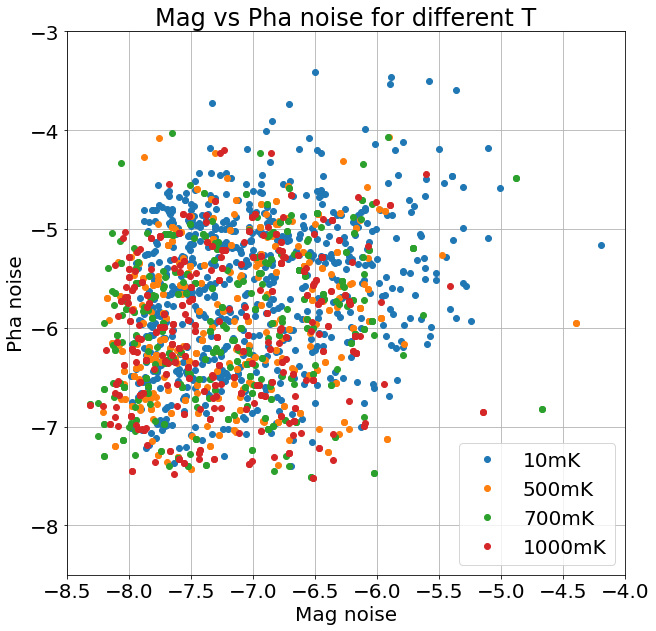

In [408]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
ax.set_title("Mag vs Pha noise for different T")
ax.set_ylabel("Pha noise")
ax.set_xlabel("Mag noise")

ax.plot(mag_ref_noise, pha_ref_noise, 'o', label='10mK')
ax.plot(mag_noise_05, pha_noise_05, 'o', label='500mK')
ax.plot(mag_noise_07, pha_noise_07, 'o', label='700mK')
ax.plot(mag_noise_1k, pha_noise_1k, 'o', label='1000mK')

ax.set_ylim(-8.5,-3)
ax.set_xlim(-8.5,-4)
ax.grid()
ax.legend()

In [395]:
mag_noise_norm_05 = np.array([])
mag_noise_norm_07 = np.array([])
mag_noise_norm_1k = np.array([])
mag_ref_noise_norm = np.array([])

pha_noise_norm_05 = np.array([])
pha_noise_norm_07 = np.array([])
pha_noise_norm_1k = np.array([])
pha_ref_noise_norm = np.array([])

for i in range(len(mag_ref_noise)):
    if mag_gain_ref_noise[i]>0:
        mag_ref_noise_norm = np.append(mag_ref_noise_norm, np.log10(mag_ref_noise[i]/np.power(10, mag_gain_ref_noise[i] / 10)))
        pha_ref_noise_norm = np.append(pha_ref_noise_norm, pha_ref_noise[i])
        
for i in range(len(mag_noise_05)):
    if mag_gain_05[i]>0:
        mag_noise_norm_05 = np.append(mag_noise_norm_05, np.log10(mag_noise_05[i]/np.power(10, mag_gain_05[i] / 10)))
        pha_noise_norm_05 = np.append(pha_noise_norm_05, pha_noise_05[i])

        
for i in range(len(mag_noise_07)):
    if mag_gain_07[i]>0:
        mag_noise_norm_07 = np.append(mag_noise_norm_07, np.log10(mag_noise_07[i]/np.power(10, mag_gain_07[i] / 10)))
        pha_noise_norm_07 = np.append(pha_noise_norm_07, pha_noise_07[i])

        
for i in range(len(mag_noise_1k)):
    if mag_gain_1k[i]>0:
        mag_noise_norm_1k = np.append(mag_noise_norm_1k, np.log10(mag_noise_1k[i]/np.power(10, mag_gain_1k[i] / 10)))
        pha_noise_norm_1k = np.append(pha_noise_norm_1k, pha_noise_1k[i])
        
pha_noise_norm_1k.shape

C:\Users\Demag\AppData\Local\Temp\ipykernel_8144\4051785686.py:13: RuntimeWarning: invalid value encountered in log10
  mag_ref_noise_norm = np.append(mag_ref_noise_norm, np.log10(mag_ref_noise[i]/np.power(10, mag_gain_ref_noise[i] / 10)))
C:\Users\Demag\AppData\Local\Temp\ipykernel_8144\4051785686.py:18: RuntimeWarning: invalid value encountered in log10
  mag_noise_norm_05 = np.append(mag_noise_norm_05, np.log10(mag_noise_05[i]/np.power(10, mag_gain_05[i] / 10)))
C:\Users\Demag\AppData\Local\Temp\ipykernel_8144\4051785686.py:24: RuntimeWarning: invalid value encountered in log10
  mag_noise_norm_07 = np.append(mag_noise_norm_07, np.log10(mag_noise_07[i]/np.power(10, mag_gain_07[i] / 10)))
C:\Users\Demag\AppData\Local\Temp\ipykernel_8144\4051785686.py:30: RuntimeWarning: invalid value encountered in log10
  mag_noise_norm_1k = np.append(mag_noise_norm_1k, np.log10(mag_noise_1k[i]/np.power(10, mag_gain_1k[i] / 10)))


(654,)

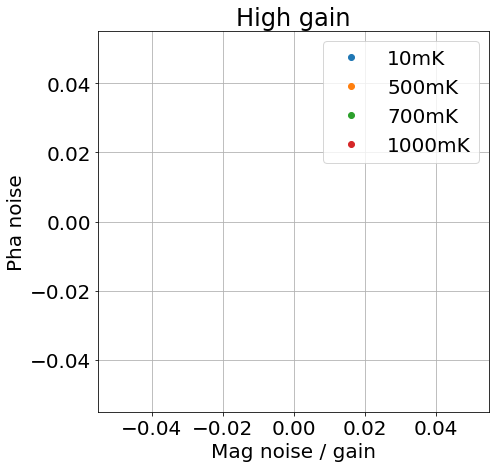

In [398]:
fig, ax = plt.subplots(1, 1, figsize=(7,7))
ax.set_title("High gain")
ax.set_ylabel("Pha noise")
ax.set_xlabel("Mag noise / gain")

ax.plot(mag_ref_noise_norm, pha_ref_noise_norm, 'o', label='10mK')
ax.plot(mag_noise_norm_05, pha_noise_norm_05, 'o', label='500mK')
ax.plot(mag_noise_norm_07, pha_noise_norm_07, 'o', label='700mK')
ax.plot(mag_noise_norm_1k, pha_noise_norm_1k, 'o', label='1000mK')

# ax.set_ylim(-5,0)
# ax.set_xlim(-0.4, 0)
ax.grid()
ax.legend()

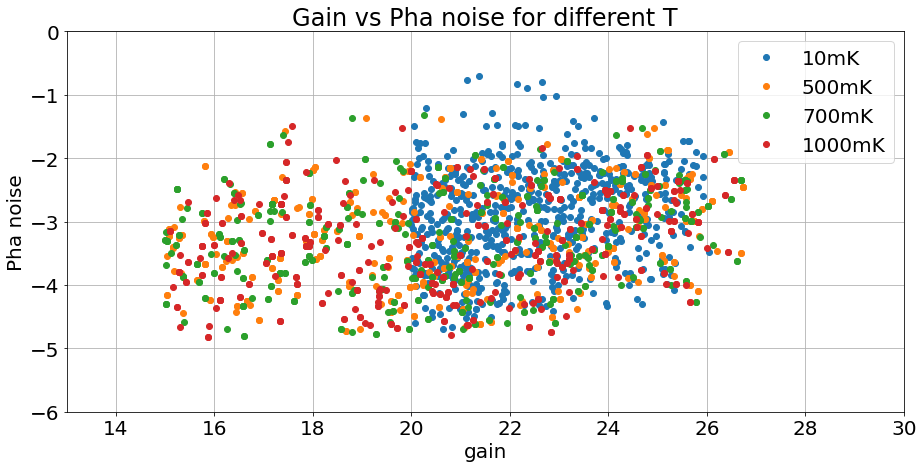

In [237]:
fig, ax = plt.subplots(1, 1, figsize=(15,7))
ax.set_title("Gain vs Pha noise for different T")
ax.set_ylabel("Pha noise")
ax.set_xlabel("gain")

ax.plot(mag_gain_ref_noise, pha_ref_noise, 'o', label='10mK')
ax.plot(mag_gain_05, pha_noise_05, 'o', label='500mK')
ax.plot(mag_gain_07, pha_noise_07, 'o', label='700mK')
ax.plot(mag_gain_1k, pha_noise_1k, 'o', label='1000mK')

ax.set_ylim(-6,0)
ax.set_xlim(13, 30)
ax.grid()
ax.legend()

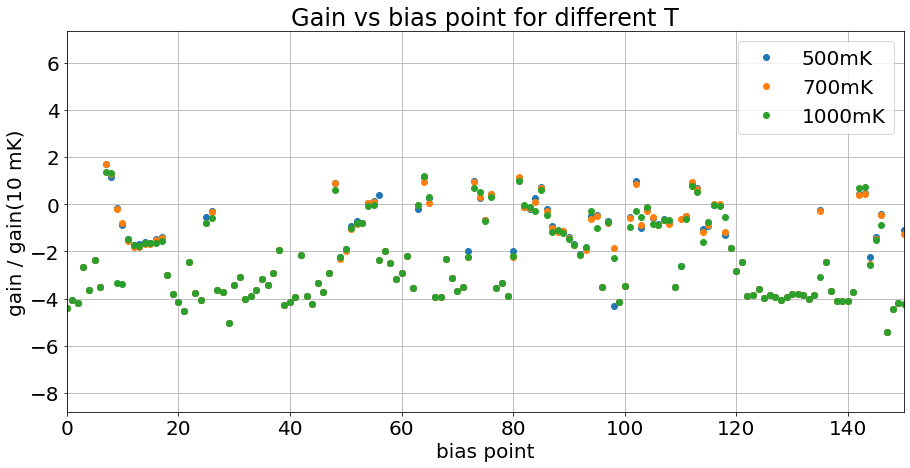

In [414]:
fig, ax = plt.subplots(1, 1, figsize=(15,7))
ax.set_title("Gain vs bias point for different T")
ax.set_ylabel("gain / gain(10 mK)")
ax.set_xlabel("bias point")

# ax.plot(mag_gain_ref_noise,  'o', label='10mK')
ax.plot(pha_noise_05-pha_ref_noise, 'o', label='500mK')
ax.plot(pha_noise_07-pha_ref_noise, 'o', label='700mK')
ax.plot(pha_noise_1k-pha_ref_noise, 'o', label='1000mK')

# ax.set_ylim(0,5)
ax.set_xlim(0, 150)
ax.grid()
ax.legend()

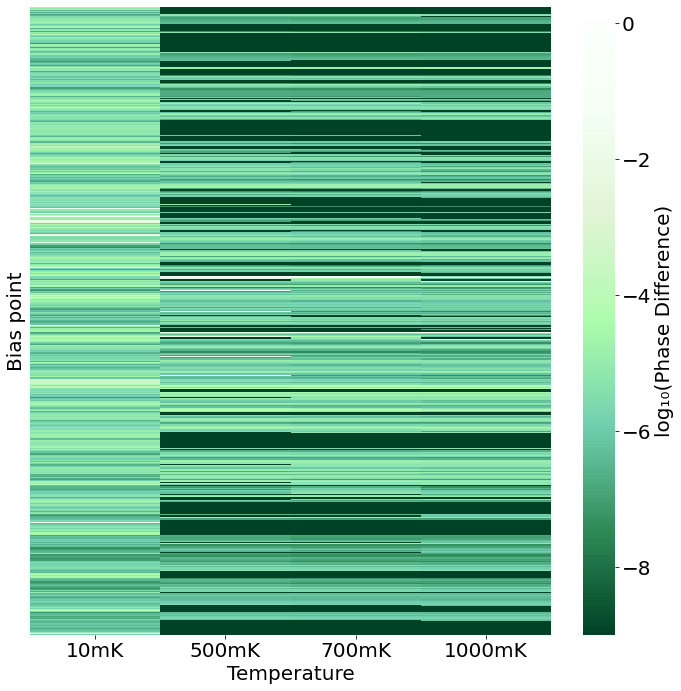

In [443]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Stack into 2D array: shape (3 temps x N parameters)
data = np.vstack([
    pha_ref_noise,
    pha_noise_05,
    pha_noise_07,
    pha_noise_1k
])

# Use absolute value before log to avoid log of negatives (if needed)
# data_log = np.log10(np.abs(data))  # small offset to avoid log(0)

# Plot with larger figure size
plt.figure(figsize=(10, 10))

colors2 = [
    '#004225ff',  # deep forest green
    '#2e8b57ff',  # sea green
    '#66cdaaee',  # medium aquamarine
    '#98fb98cc',  # pale green
    '#d0f0c0aa',  # tea green
    '#f0fff0aa',  # honeydew
    '#ffffffcc',  # white
]
cmap2 = LinearSegmentedColormap.from_list('my_cmap', colors2, N=256)

# Heatmap
sns.heatmap(
    data.T,
    cmap=cmap2,
    yticklabels=False,
    xticklabels=['10mK', '500mK', '700mK', '1000mK'],
    cbar_kws={'label': 'log₁₀(Phase Difference)'}
)

plt.xlabel('Temperature')
plt.ylabel('Bias point')
plt.tight_layout()

plt.savefig(r"C:\Users\Demag\PycharmProjects\ColdMeasurements\DeMag\DATA\TWPA_noise_9\paper_plots\covt.png", dpi=300, bbox_inches='tight')
plt.show()